In [143]:
import pandas as pd
import numpy as np

In [144]:
train = pd.read_csv(f"../../乳癌液態/GSE89093/GSE89093_all_beta_normalized.csv")

In [145]:
train_value = train.iloc[:, 1:]
train_value.head()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.486644,0.472790,0.440157,0.401009,0.403449,0.453738,0.505430,0.525945,0.539579,0.378885,...,0.586559,0.557733,0.515352,0.570047,0.586289,0.428182,0.410767,0.535594,0.561125,0.534982
1,0.989213,0.993538,0.991012,0.995878,0.996242,0.992823,0.990628,0.992809,0.999285,0.998130,...,0.980657,0.994747,0.987606,0.994711,0.982437,0.982954,0.994045,0.987665,0.993932,0.991112
2,0.984875,0.951471,0.948615,0.949571,0.963231,0.972137,0.972501,0.969343,0.950113,0.964967,...,0.966235,0.960497,0.955022,0.955616,0.936133,0.955798,0.937965,0.965013,0.942853,0.945216
3,0.102033,0.168589,0.158073,0.141595,0.124284,0.179538,0.181141,0.198009,0.171876,0.160247,...,0.164425,0.146259,0.162503,0.170724,0.151290,0.113963,0.176928,0.133602,0.147707,0.166224
4,0.798909,0.720664,0.745585,0.751120,0.738786,0.777767,0.776491,0.839313,0.830973,0.844176,...,0.795153,0.799779,0.796590,0.831788,0.794952,0.783985,0.720944,0.756649,0.848983,0.820339


In [156]:
phe = pd.read_csv("../../乳癌液態/GSE89093/GSE89093_phenotype.csv")
phe = pd.DataFrame(phe["cancer_status"])
mask = phe == 'healthy'

In [157]:
train_normal = train_value.iloc[:,np.nonzero(mask.T)[1]]
train_tumor = train_value.iloc[:,np.nonzero(~mask.T)[1]]
train_normal = train_normal.T.reset_index(drop=True).T
train_tumor = train_tumor.T.reset_index(drop=True).T

In [158]:
train_normal=train_normal.iloc[:-1,:]
train_tumor=train_tumor.iloc[:-1,:]


In [159]:
train_normal = train_normal.astype(float)
train_tumor = train_tumor.astype(float)
# train_normal

##### Calculate Δβ

In [160]:
# remove outlier based on every column
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + IQR*1.5
    lower_fence = Q1 - IQR*1.5
    return upper_fence,lower_fence
def no_outlier(df):
    upper_fence, lower_fence = IQR(df)
    ddf=df[(df>lower_fence)&(df<upper_fence)]
    return ddf

In [161]:
train_normal = no_outlier(train_normal)
train_tumor = no_outlier(train_tumor)

In [162]:
train_normal_avg = train_normal.mean(skipna=True, axis = 1)
train_normal_avg

0         0.519146
1         0.990404
2         0.953030
3         0.184443
4         0.805800
            ...   
453621    0.022224
453622    0.010784
453623    0.013459
453624    0.020409
453625    0.108378
Length: 453626, dtype: float64

In [163]:
train_tumor=(train_tumor).subtract(train_normal_avg, axis = 0)

In [164]:
train_tumor=no_outlier(train_tumor)

In [165]:
train_tumor_mean = train_tumor.mean(skipna=True, axis = 1)

In [166]:
dbeta = pd.merge(train.iloc[:-1,:1], pd.DataFrame(train_tumor_mean, columns = ["dbeta"]), left_index=True, right_index=True)
dbeta

,ID_REF,dbeta
0,cg00000029,0.009136
1,cg00000108,0.000004
2,cg00000109,0.002752
3,cg00000165,-0.003757
4,cg00000236,0.011955
...,...,...
453621,ch.9.97139671F,-0.000039
453622,ch.9.98463211R,-0.000344
453623,ch.9.98937537R,-0.000823
453624,ch.9.98957343R,0.000250


In [167]:
# rename ID_REF to ID
dbeta.rename(columns={"ID_REF": "ID"}, inplace=True)

Text(0.5, 1.0, 'Density plot of delta Beta value')

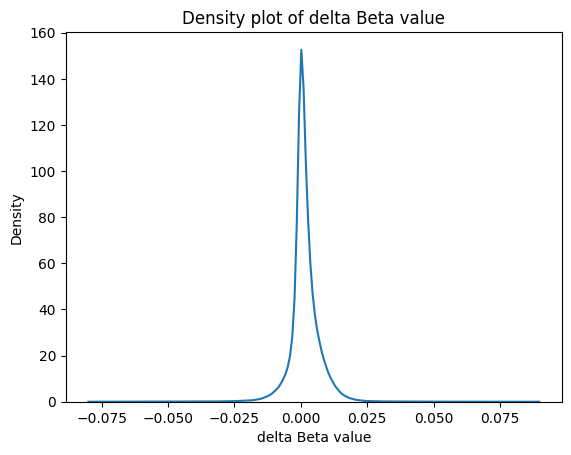

In [168]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(dbeta['dbeta'], label='healthy')
plt.xlabel('delta Beta value')
plt.title('Density plot of delta Beta value')

In [169]:
GPL13534 = pd.read_csv("../external_result/GPL13534-11288.txt", sep="\t")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18480\1119215373.py:1: DtypeWarning: Columns (11,14,15,36) have mixed types. Specify dtype option on import or set low_memory=False.
  GPL13534 = pd.read_csv("../external_result/GPL13534-11288.txt", sep="\t")


In [170]:
GPL13534.columns

Index(['ID', 'Name', 'AddressA_ID', 'AlleleA_ProbeSeq', 'AddressB_ID',
       'AlleleB_ProbeSeq', 'Infinium_Design_Type', 'Next_Base',
       'Color_Channel', 'Forward_Sequence', 'Genome_Build', 'CHR', 'MAPINFO',
       'SourceSeq', 'Chromosome_36', 'Coordinate_36', 'Strand', 'Probe_SNPs',
       'Probe_SNPs_10', 'Random_Loci', 'Methyl27_Loci', 'UCSC_RefGene_Name',
       'UCSC_RefGene_Accession', 'UCSC_RefGene_Group', 'UCSC_CpG_Islands_Name',
       'Relation_to_UCSC_CpG_Island', 'Phantom', 'DMR', 'Enhancer',
       'HMM_Island', 'Regulatory_Feature_Name', 'Regulatory_Feature_Group',
       'DHS', 'RANGE_START', 'RANGE_END', 'RANGE_GB', 'SPOT_ID'],
      dtype='object')

In [171]:
GPL13534 = GPL13534[["ID", "UCSC_RefGene_Name", "UCSC_RefGene_Group"]]
GPL13534.dropna(inplace=True)
GPL13534

,ID,UCSC_RefGene_Name,UCSC_RefGene_Group
0,cg00035864,TTTY18,TSS1500
1,cg00050873,TSPY4;FAM197Y2,Body;TSS1500
2,cg00061679,DAZ1;DAZ4;DAZ4,Body;Body;Body
3,cg00063477,EIF1AY,Body
4,cg00121626,BCORL2,Body
...,...,...,...
485501,ch.22.734399R,EP300,Body
485502,ch.22.740407F,RANGAP1,Body
485503,ch.22.757911F,XRCC6,Body
485504,ch.22.772318F,NAGA,Body


In [172]:
result = pd.merge(dbeta, GPL13534, on="ID", how="inner")
result

,ID,dbeta,UCSC_RefGene_Name,UCSC_RefGene_Group
0,cg00000029,0.009136,RBL2,TSS1500
1,cg00000108,0.000004,C3orf35;C3orf35,Body;3'UTR
2,cg00000109,0.002752,FNDC3B;FNDC3B,Body;Body
3,cg00000236,0.011955,VDAC3;VDAC3,3'UTR;3'UTR
4,cg00000289,0.007991,ACTN1;ACTN1;ACTN1,3'UTR;3'UTR;3'UTR
...,...,...,...,...
344526,ch.9.357218F,0.002161,ADAMTSL1;ADAMTSL1,Body;Body
344527,ch.9.377428R,-0.001230,ACER2,Body
344528,ch.9.691424R,-0.000346,RNF38;RNF38;RNF38;RNF38;RNF38,3'UTR;3'UTR;3'UTR;3'UTR;3'UTR
344529,ch.9.837340R,-0.002480,PTAR1,Body


In [173]:
result['UCSC_RefGene_Name'] = result['UCSC_RefGene_Name'].str.split(';').str[0]
result['UCSC_RefGene_Group'] = result['UCSC_RefGene_Group'].str.split(';').str[0]
result.dropna(inplace=True)

In [174]:
def find_max_dBeta_grouped(group):
    idx_max = group['dbeta'].abs().idxmax()
    return group.loc[idx_max]

result_max_per_gene = result.groupby("UCSC_RefGene_Name").apply(find_max_dBeta_grouped).reset_index(drop=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18480\563322187.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_max_per_gene = result.groupby("UCSC_RefGene_Name").apply(find_max_dBeta_grouped).reset_index(drop=True)


In [175]:
single = pd.read_csv('../comorbidity/matchgene174_single_3Y10__OR2.txt', sep='\t', header=None)

In [176]:
result_max_per_gene_single = result_max_per_gene[result_max_per_gene['UCSC_RefGene_Name'].isin(single[0])]
result_max_per_gene_single

,ID,dbeta,UCSC_RefGene_Name,UCSC_RefGene_Group
1,cg16531903,0.013321,A1CF,TSS1500
4,cg27166707,-0.006354,A2M,Body
5,cg24309769,-0.074597,A2ML1,Body
12,cg13001012,0.007991,AADAC,TSS1500
16,cg25628542,0.034433,AADAT,Body
...,...,...,...,...
19351,cg06155771,0.013769,ZNRD1,Body
19354,cg16483867,-0.013046,ZNRF3,Body
19371,cg22721334,-0.013064,ZSCAN18,1stExon
19391,cg16899823,-0.021684,ZWINT,TSS200


In [177]:
file_endings="GSE89093"

In [178]:
result_max_per_gene_single.to_csv(f"../result/result_basic_dbeta_{file_endings}.csv", index=False)

Lazy reading, skip when exectuing the code from top to bottom.

In [179]:
result_basic_dbeta = pd.read_csv(f"../result/result_basic_dbeta_{file_endings}.csv")

In [180]:
dbeta_process_liquid = result_basic_dbeta.copy()
dbeta_process_liquid

,ID,dbeta,UCSC_RefGene_Name,UCSC_RefGene_Group
0,cg16531903,0.013321,A1CF,TSS1500
1,cg27166707,-0.006354,A2M,Body
2,cg24309769,-0.074597,A2ML1,Body
3,cg13001012,0.007991,AADAC,TSS1500
4,cg25628542,0.037536,AADAT,Body
...,...,...,...,...
8119,cg06155771,0.013769,ZNRD1,Body
8120,cg16483867,-0.013046,ZNRF3,Body
8121,cg22721334,-0.013064,ZSCAN18,1stExon
8122,cg16899823,-0.021684,ZWINT,TSS200


Filter by TSS1500 & TSS200 (Optional)

In [ ]:
# remove rows that UCSC_RefGene_Group != 'TSS200' or 'TSS1500'
dbeta_process_liquid = dbeta_process_liquid[dbeta_process_liquid['UCSC_RefGene_Group'].isin(['TSS200', 'TSS1500'])]
dbeta_process_liquid

In [9]:
result_max_per_gene_single = pd.read_csv(f"../result/result_basic_process.csv")

In [ ]:
dbeta_process_tissue = result_max_per_gene_single.copy()
dbeta_process_tissue.columns = ['ID', 'dbeta', 'UCSC_RefGene_Name']
dbeta_process_tissue

In [ ]:
# intersect between liquid and tissue
interseted = pd.merge(dbeta_process_liquid, dbeta_process_tissue, on="ID", how="inner")
interseted = interseted[(interseted['dbeta_x'] * interseted['dbeta_y']) > 0]
interseted = interseted.drop(columns=['UCSC_RefGene_Name_y'])
interseted = interseted.rename(columns={'UCSC_RefGene_Name_x': 'UCSC_RefGene_Name'})
interseted = interseted.rename(columns={'dbeta_x': 'dbeta_liquid'})
interseted = interseted.rename(columns={'dbeta_y': 'dbeta_tissue'})
interseted = interseted[['ID', 'UCSC_RefGene_Name', 'dbeta_liquid', 'dbeta_tissue']]
print(interseted.shape)
interseted

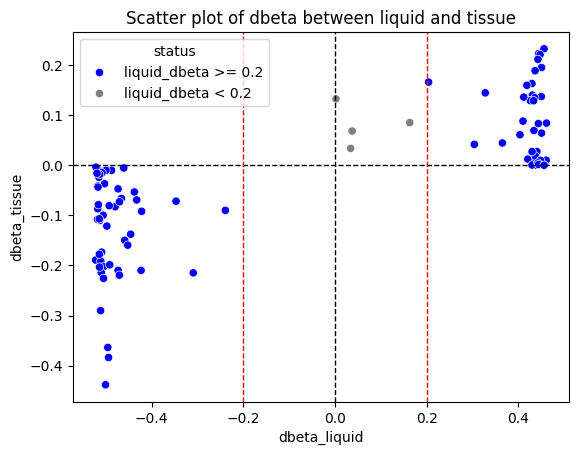

In [12]:
# draw scatter plot for liquid and tissue
import matplotlib.pyplot as plt
import seaborn as sns
interseted['status'] = np.where(abs(interseted['dbeta_liquid']) < 0.2, 'liquid_dbeta < 0.2', 'liquid_dbeta >= 0.2')

sns.scatterplot(
    data=interseted,
    x='dbeta_liquid',
    y='dbeta_tissue',
    hue='status',
    palette=['blue', 'gray'])
plt.xlabel('dbeta_liquid')
plt.ylabel('dbeta_tissue')
plt.title('Scatter plot of dbeta between liquid and tissue')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0.2, color='red', linewidth=1, linestyle='--')
plt.axvline(-0.2, color='red', linewidth=1, linestyle='--')
plt.show()

In [ ]:
interseted = interseted[abs(interseted['dbeta_liquid']) >= 0.2]
interseted = interseted.drop(columns=['status'])
print(interseted.shape)
interseted

In [14]:
interseted.to_csv(f"../result/train_and_GSE89093_interseted.csv", index=False)